In [1]:
import sys; sys.version

'3.10.12 (main, Nov 20 2023, 15:14:05) [GCC 11.4.0]'

LOADING DATA FROM KAGGLE

In [2]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [3]:
!kaggle datasets download -d hasnainjaved/melanoma-skin-cancer-dataset-of-10000-images

 82% 81.0M/98.7M [00:00<00:00, 129MB/s]
100% 98.7M/98.7M [00:00<00:00, 120MB/s]


In [4]:
import zipfile
zip_ref = zipfile.ZipFile('/content/melanoma-skin-cancer-dataset-of-10000-images.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [5]:
import tensorflow as tf, numpy as np, pandas as pd
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten

In [6]:
train_path = '/content/melanoma_cancer_dataset/train'
ds = keras.utils.image_dataset_from_directory(
    directory = train_path,
    labels= 'inferred',
    label_mode= 'int',
    batch_size= 32,
    image_size = (256, 256),
    shuffle =True,
)

Found 9605 files belonging to 2 classes.


In [26]:
test_path = '/content/melanoma_cancer_dataset/test'
test= keras.utils.image_dataset_from_directory(
    directory = test_path,
    labels= 'inferred',
    label_mode= 'int',
    batch_size= 32,
    image_size= (256, 256),
    shuffle = True,
)

Found 1000 files belonging to 2 classes.


DATASET SPLITTING

In [8]:
DATASET_SIZE= len(ds)
TRAIN_RATIO, VALIDATION_RATIO = 0.8, 0.2
train = ds.take(int(DATASET_SIZE*TRAIN_RATIO))
val  = ds.skip(int(DATASET_SIZE*TRAIN_RATIO))

print(len(train), len(val))

240 61


DATASET VISUALIZATION

In [9]:
import matplotlib.pyplot as plt

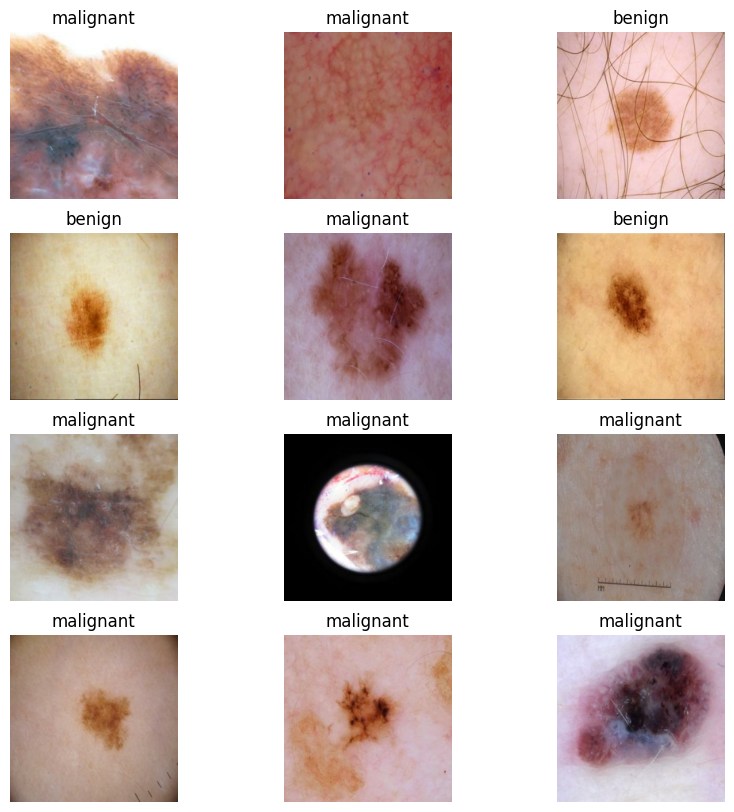

In [10]:
class_names = ds.class_names
plt.figure(figsize= (10,10))
for image_batch, label_batch in ds.take(1):
    for i in range(12):
        ax = plt.subplot(4,3,i+1)
        plt.imshow(image_batch[i].numpy().astype('uint8'))
        plt.title(class_names[label_batch[i]]); plt.axis('off')

MODEL BUILDING

In [11]:
from keras.layers import RandomFlip, RandomRotation

In [12]:
Augmentation = Sequential([
    RandomFlip("horizontal_and_vertical"),
    RandomRotation(0.2),
])

In [39]:
def Normalizer(image, label):
    image= tf.cast(image/255., tf.float32)
    return image, label
train, val, test = train.map(Normalizer), val.map(Normalizer), test.map(Normalizer)

In [14]:
model = Sequential([
    Augmentation,
    Conv2D(32, kernel_size=(3,3), activation='relu', input_shape=(32, 256, 256, 3)),
    MaxPooling2D(pool_size=(2,2)),
    Conv2D(32, kernel_size=(3,3), activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    Conv2D(32, kernel_size=(3,3), activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    Conv2D(32, kernel_size=(3,3), activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    Conv2D(32, kernel_size=(3,3), activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    Conv2D(32, kernel_size=(3,3), activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    Flatten(),
    Dense(units=64, activation="relu"),
    Dense(units=2, activation="Softmax"),
])
model.build (input_shape=(32, 256, 256, 3))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (32, 127, 127, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 62, 62, 32)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (32, 60, 60, 32)         

In [15]:
model.compile(
    optimizer= 'adam',
    loss=  'sparse_categorical_crossentropy',
    metrics = ['accuracy',]
)

MODEL TRAINING

In [16]:
history = model.fit(train, batch_size= 32, epochs=10, verbose=1, validation_data=val)

Epoch 1/10
240/240 [==============================] - 32s 100ms/step - loss: 0.5032 - accuracy: 0.7389 - val_loss: 0.3498 - val_accuracy: 0.8416
Epoch 2/10
240/240 [==============================] - 28s 114ms/step - loss: 0.3582 - accuracy: 0.8443 - val_loss: 0.3245 - val_accuracy: 0.8597
Epoch 3/10
240/240 [==============================] - 25s 103ms/step - loss: 0.3344 - accuracy: 0.8569 - val_loss: 0.3475 - val_accuracy: 0.8603
Epoch 4/10
240/240 [==============================] - 24s 97ms/step - loss: 0.3107 - accuracy: 0.8681 - val_loss: 0.3149 - val_accuracy: 0.8660
Epoch 5/10
240/240 [==============================] - 23s 94ms/step - loss: 0.3112 - accuracy: 0.8694 - val_loss: 0.2974 - val_accuracy: 0.8732
Epoch 6/10
240/240 [==============================] - 24s 98ms/step - loss: 0.2985 - accuracy: 0.8715 - val_loss: 0.2852 - val_accuracy: 0.8774
Epoch 7/10
240/240 [==============================] - 24s 97ms/step - loss: 0.2965 - accuracy: 0.8749 - val_loss: 0.2730 - val_accura

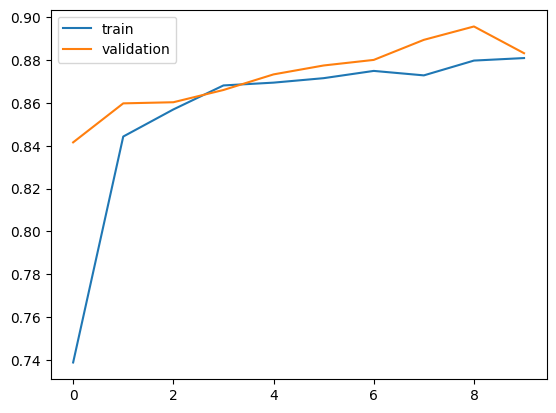

In [17]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['train', 'validation'])

MODEL EVALUATION

In [40]:
loss, accuracy = model.evaluate(test); print(loss, accuracy)

32/32 [==============================] - 2s 52ms/step - loss: 0.2490 - accuracy: 0.8870
0.2490210235118866 0.8870000243186951


Actual Label:  malignant
1/1 [==============================] - 0s 34ms/step
Predicted Label:  malignant


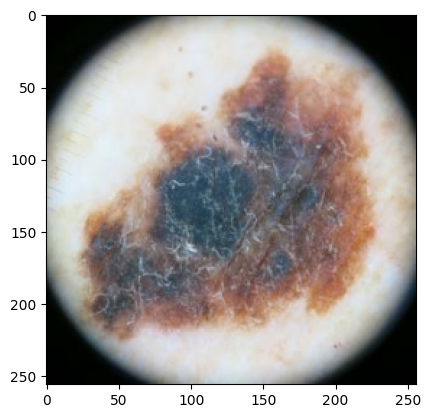

In [52]:
for images, label in test.take(1):
  img = (images[0]*255).numpy().astype('uint8')
  plt.imshow(img)
  print('Actual Label: ', class_names[label[0].numpy()])
  pred = model.predict(images)
  print('Predicted Label: ', class_names[np.argmax(pred[0])])